# BBC News Classification

## Topic

We will use a public dataset from the BBC comprised of 2225 articles, (from kaggle), each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

I am going to use unsupervised model like NMF, supervised model like KNN, logistic regression to predit the news's category, and compare different model's performance.

[GitHub Repo](https://github.com/BaffinLee/BBC-News-Classification)

In [92]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Data

The train and test data is from [kaggle](https://www.kaggle.com/c/learn-ai-bbc/data).

File descriptions
- BBC_News_Train.csv - the training set of 1490 records
- BBC_News_Test.csv - the test set of 736 records


Data fields
- ArticleId - Article id unique, number
- Article - text of the header and article
- Category - cateogry of the article (tech, business, sport, entertainment, politics)

In [93]:
train = pd.read_csv('https://raw.githubusercontent.com/BaffinLee/BBC-News-Classification/main/BBC_News_Train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/BaffinLee/BBC-News-Classification/main/BBC_News_Test.csv')

## Exploratory Data Analysis

First of all, let's take a look at the data structure of test and train data.

The train data has three columns: ArticleId, Text, Caregory


The train data has two columns: ArticleId, Text

In [94]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [95]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


Than we can remove duplicate articles if there are any.

Here we can see there are 50 duplicate articles, I removed them.

In [96]:
print(train.nunique())
train = train.drop_duplicates(subset=['Text'], ignore_index=True)
print(train.nunique())

ArticleId    1490
Text         1440
Category        5
dtype: int64
ArticleId    1440
Text         1440
Category        5
dtype: int64


Let's see how all the category lables distribute and plot it.

Through the plot we draw, we know that there are more business and sport articles than politics, tech and entertainment articles.

In [97]:
train['Category'].value_counts()

Category
sport            342
business         335
politics         266
entertainment    263
tech             234
Name: count, dtype: int64

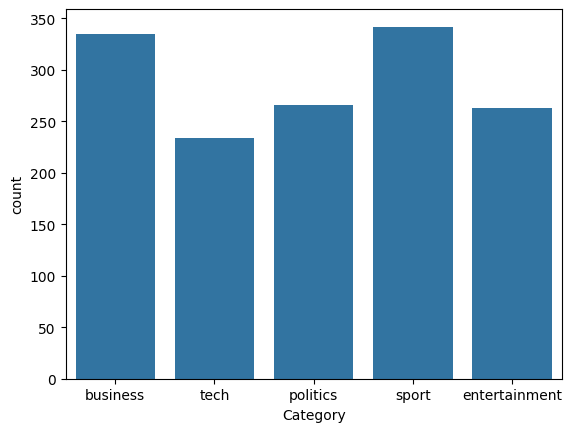

In [98]:
sns.countplot(x='Category', data=train)
plt.show()

Let's find out how the article length distribute and plot it for analyse.

In [99]:
lens = train['Text'].map(lambda txt: len(txt))
lens.describe()

count     1440.000000
mean      2234.261806
std       1211.698556
min        501.000000
25%       1451.250000
50%       1964.000000
75%       2754.000000
max      18387.000000
Name: Text, dtype: float64

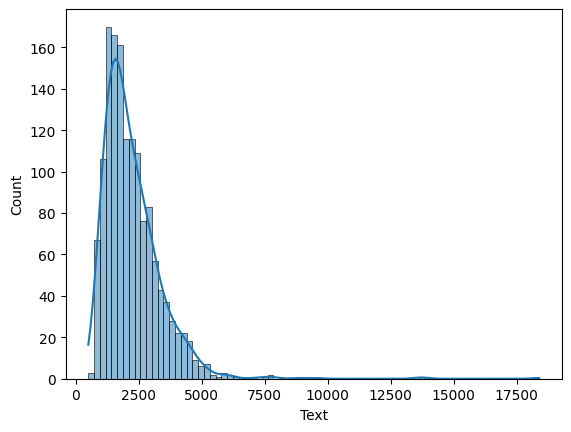

In [100]:
sns.histplot(lens, kde=True)
plt.show()

The plot tells us that most articles have about 2000 characters, very few of them have characters more than 5500.

The distribute of the number of words in an article is like the distribute of article length, so I am not going to plot it here.

## Data processing

Turning Text into numbers.

Accordding to [Wiki Pedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), tf–idf (term frequency–inverse document frequency), is a measure of importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general. It was often used as a weighting factor in searches of information retrieval, text mining, and user modeling.

In this project, I am going to use TfidfVectorizer from Sklearn to transform article's text into numbers.

In [101]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = tfidf.fit_transform(train['Text'])
column_names = tfidf.get_feature_names_out()
train_articles = pd.DataFrame(doc_term_matrix.toarray(), columns=column_names)
print(train_articles.info())
train_articles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Columns: 13752 entries, 00 to zvonareva
dtypes: float64(13752)
memory usage: 151.1 MB
None


,00,000,000m,000th,007,01,0100,0130,028,03,...,zoe,zola,zombie,zombies,zone,zones,zoom,zooms,zurich,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.024543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Unsupervised Learning: Non-negative Matrix Factorization (NMF)

In this section I going to train Non-negative Matrix Factorization model and predict BBC article's label.

To begin with, I will choose frobenius as loss function, which is also the default parameter of NMF from sklearn.

In [102]:
label_num = 5

model = NMF(n_components=label_num, beta_loss='frobenius')
model.fit(doc_term_matrix)
W = model.transform(doc_term_matrix)
H = model.components_

Display the top words for each category.

In [103]:
for cat_idx, cat in enumerate(H):
  print(f"Topic No.{cat_idx}:")
  words_idx = cat.argsort()[:-10 - 1:-1]
  for i in words_idx:
    print(f'word: {column_names[i]}, weight: {cat[i]}')
  print()

Topic No.0:
word: england, weight: 0.5428831554228255
word: game, weight: 0.4712550132380927
word: win, weight: 0.3489640069382681
word: wales, weight: 0.3300563040195184
word: ireland, weight: 0.3190387195519676
word: cup, weight: 0.3091039333456824
word: said, weight: 0.2974770697716065
word: team, weight: 0.2856351247361529
word: play, weight: 0.27322477176811094
word: players, weight: 0.26623457465518435

Topic No.1:
word: mr, weight: 0.6794858901387808
word: labour, weight: 0.5642393693690467
word: election, weight: 0.4942080341986707
word: blair, weight: 0.47040776503655296
word: brown, weight: 0.3935323528156711
word: party, weight: 0.3755281844750478
word: said, weight: 0.3248613302698403
word: government, weight: 0.27506170944409464
word: minister, weight: 0.2540075366631003
word: howard, weight: 0.24920498218199158

Topic No.2:
word: growth, weight: 0.38262624345717167
word: economy, weight: 0.32700113338411935
word: said, weight: 0.3239797440930737
word: sales, weight: 0.268

By the top words of each topic, we can easily guess each topic's name. For example, this topic No.4 with top words like mobile, music, phone, technology is most likely the Tech category.

Let's calculate the score of our trained NMP model.

In [104]:
best_order = None

def cal_accuracy(y, y_predict):
  labels = np.unique(y_predict)
  ordering = permutations(labels)
  best_accuracy = 0.0
  global best_order
  for order in ordering:
      # Create a mapping of yp according to order
      label_mapping = dict(zip(labels, order))
      reordered_y_predict = np.array([label_mapping[idx] for idx in y_predict])

      accuracy = accuracy_score(y, reordered_y_predict)
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_order = order
  return best_accuracy

In [105]:
mapping = dict(zip(train['Category'].unique(), list(range(5))))
labels = [mapping[c] for c in train.Category]

frobenius_accuracy = cal_accuracy(labels, np.argmax(W, axis=1))
print(frobenius_accuracy)

0.9104166666666667


Here we got training accuracy about 0.91, which is pretty good. Let's change some hyperparameters to try if we can get a better performance.

Use kullback-leibler loss function.

In [106]:
model = NMF(n_components=label_num, beta_loss='kullback-leibler', solver='mu')
model.fit(doc_term_matrix)
W = model.transform(doc_term_matrix)
H = model.components_

kullback_accuracy = cal_accuracy(labels, np.argmax(W, axis=1))
print(kullback_accuracy)

0.9590277777777778


Use different alpha_W and alpha_H.

In [107]:
accuracy_list = [
  ('frobenius', frobenius_accuracy),
  ('kullback-leibler', kullback_accuracy),
];

alpha_Ws = [0, 0.01, 0.05]
alpha_Hs = [0, 0.01, 0.05]
for w in alpha_Ws:
  for h in alpha_Hs:
    model = NMF(n_components=label_num, beta_loss='kullback-leibler', solver='mu', alpha_W=w, alpha_H=h)
    model.fit(doc_term_matrix)
    W = model.transform(doc_term_matrix)
    H = model.components_
    accuracy = cal_accuracy(labels, np.argmax(W, axis=1))
    accuracy_list.append((f'kullback-leibler with alpha_W={w} alpha_H={h}', accuracy))


In [108]:
print(f'model         accuracy')
for item in accuracy_list:
  print(f'{item[0]} {item[1]}')

model         accuracy
frobenius 0.9104166666666667
kullback-leibler 0.9590277777777778
kullback-leibler with alpha_W=0 alpha_H=0 0.9590277777777778
kullback-leibler with alpha_W=0 alpha_H=0.01 0.9597222222222223
kullback-leibler with alpha_W=0 alpha_H=0.05 0.9583333333333334
kullback-leibler with alpha_W=0.01 alpha_H=0 0.9583333333333334
kullback-leibler with alpha_W=0.01 alpha_H=0.01 0.9576388888888889
kullback-leibler with alpha_W=0.01 alpha_H=0.05 0.9590277777777778
kullback-leibler with alpha_W=0.05 alpha_H=0 0.9597222222222223
kullback-leibler with alpha_W=0.05 alpha_H=0.01 0.9569444444444445
kullback-leibler with alpha_W=0.05 alpha_H=0.05 0.9576388888888889


After we dit hyperparameter fine tuning, we got best accuracy model use parameter:
- loss function: kullback-leibler
- alpha_W=0
- alpha_H=0.01
- accuracy=0.9597222222222223


In [109]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = tfidf.fit_transform(train['Text'])
model = NMF(n_components=label_num, beta_loss='kullback-leibler', solver='mu', alpha_W=0, alpha_H=0.01)
model.fit(doc_term_matrix)
W = model.transform(doc_term_matrix)
H = model.components_
predictions = np.argmax(W, axis=1)
NMF_score = cal_accuracy(labels, np.argmax(W, axis=1))
print(NMF_score)

unique_labels = np.unique(predictions)
label_mapping = dict(zip(unique_labels, best_order))
levels = pd.Index(mapping.keys())
reordered_predictions = np.array([label_mapping[index] for index in predictions])

0.9597222222222223


Let's inspect the best models confusion map.

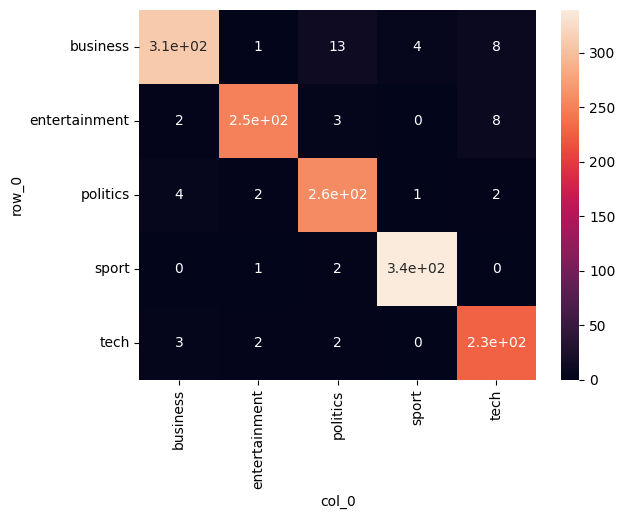

In [110]:

confusion_matrix = pd.crosstab(levels[labels], levels[reordered_predictions])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

Let's use the best model to generate test predictions.

In [111]:
doc_term_matrix_test = tfidf.transform(test['Text'])
test_W = model.transform(doc_term_matrix_test)
test_predictions = np.argmax(test_W, axis=1)
reordered_test_predictions = np.array([label_mapping[index] for index in test_predictions])
test_predicted_labels = levels[reordered_test_predictions]

submission = pd.DataFrame({
  'ArticleId': test['ArticleId'],
  'Category': test_predicted_labels
})

submission.head(20)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


## Supervised Learning: KNN and Logistic Regression Classfier

I am going to use KNN and Logistic Regression Classfier model to predict news category, and then compare it with NMF model above.

Prepare data.

In [112]:
X = doc_term_matrix
y = labels

KNeighborsClassifier

In [113]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(X, y)
KNN_score = KNN_model.score(X, y)
print(KNN_score)

0.95625


Logistic Regression Classfier

In [114]:
LR_model = LogisticRegression()
LR_model.fit(X, y)
LR_score = LR_model.score(X, y)
print(LR_score)

0.9972222222222222


Summarize

In [115]:
result = pd.DataFrame([
    ['NMF', NMF_score],
    ['KNeighborsClassifier', KNN_score],
    ['LogisticRegression', LR_score],
], columns=['Classifier', 'Accuracy'])

result.head()

,Classifier,Accuracy
0,NMF,0.959722
1,KNeighborsClassifier,0.956250
2,LogisticRegression,0.997222


As the summary shows, LogisticRegression model has the best train accuracy, let's use this model to submit final prediction for test data.



In [116]:
LR_predict = LR_model.predict(doc_term_matrix_test)
LR_predict_labels = [levels[id] for id in LR_predict]

submission = pd.DataFrame({
  'ArticleId': test['ArticleId'],
  'Category': LR_predict_labels
})

submission.to_csv('submission.csv', index=False)

submission.head(20)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


## Discussions

In this project, I used NMF, KNN, LogisticRegression to train and predict BBC news category, the LogisticRegression has the best train accuracy, and is the most fast model in this case, so that I submited this model's prediction to kaggle test.

The score after I submit it to kaggle platform is 0.98231

## Reference

- Geena Kim: Lecture Notes on Non-Negative Matrix Factorization (NMF)
- [https://www.kaggle.com/code/wellyw/unsupervised-and-supervised-classification](https://www.kaggle.com/code/wellyw/unsupervised-and-supervised-classification)
- [https://www.kaggle.com/c/learn-ai-bbc/overview](https://www.kaggle.com/c/learn-ai-bbc/overview)
- [https://en.wikipedia.org/wiki/Tf%E2%80%93idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- [https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification)